In [0]:
import glob
import numpy as np
import os
import shutil
np.random.seed(42)
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
files = glob.glob('/content/drive/My Drive/data/*')

true_files = [fn for fn in files if 'true' in fn]
false_files = [fn for fn in files if 'false' in fn]
len(true_files), len(false_files)

(934, 953)

In [0]:
true_train = np.random.choice(true_files, size=500, replace=False)
false_train = np.random.choice(false_files, size=500, replace=False)
true_files = list(set(true_files) - set(true_train))
false_files = list(set(false_files) - set(false_train))

true_val = np.random.choice(true_files, size=200, replace=False)
false_val = np.random.choice(false_files, size=200, replace=False)
true_files = list(set(true_files) - set(true_val))
false_files = list(set(false_files) - set(false_val))

true_test = np.random.choice(true_files, size=200, replace=False)
false_test = np.random.choice(false_files, size=200, replace=False)

print('True datasets:', true_train.shape, true_val.shape, true_test.shape)
print('False datasets:', false_train.shape, false_val.shape, false_test.shape)

True datasets: (500,) (200,) (200,)
False datasets: (500,) (200,) (200,)


In [0]:
train_dir = 'training_data'
val_dir = 'validation_data'
test_dir = 'test_data'

train_files = np.concatenate([true_train, false_train])
validate_files = np.concatenate([true_val, false_val])
test_files = np.concatenate([true_test, false_test])

os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

for fn in train_files:
    shutil.copy(fn, train_dir)

for fn in validate_files:
    shutil.copy(fn, val_dir)
    
for fn in test_files:
    shutil.copy(fn, test_dir)

In [0]:
IMG_DIM = (100, 100)

train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[1].split(' ')[0].strip() for fn in train_files]

validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[1].split(' ')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (1400, 100, 100, 3) 	Validation dataset shape: (512, 100, 100, 3)


(100, 100, 3)


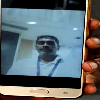

In [0]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [0]:
batch_size = 10
num_classes = 2
epochs = 100
input_shape = (100, 100, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[695:700], train_labels_enc[695:700])

['false', 'true', 'false', 'false', 'true'] [0 1 0 0 1]


In [0]:
from keras.applications import vgg16
from keras.models import Model
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f115cd3e5f8>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7f115cd3e748>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7f115cd3e978>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7f115ccdcc88>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7f115ccdc470>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7f115c48e400>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7f115c4a1c88>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7f115c4a12e8>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7f115c44e7b8>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7f115c467a90>,block3_conv3,False


(1, 3, 3, 512)


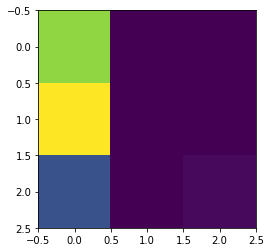

In [0]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [0]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (1400, 4608) 	Validation Bottleneck Features: (200, 4608)


In [0]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

input_shape = vgg_model.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               2359808   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 2,622,977
Trainable params: 

In [0]:
history = model.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 1400 samples, validate on 200 samples
Epoch 1/30
1400/1400 [==============================] - 1s 604us/step - loss: 0.1343 - acc: 0.9550 - val_loss: 0.0240 - val_acc: 0.9950
Epoch 2/30
1400/1400 [==============================] - 0s 248us/step - loss: 0.0295 - acc: 0.9871 - val_loss: 0.0197 - val_acc: 0.9950
Epoch 3/30
1400/1400 [==============================] - 0s 256us/step - loss: 0.0208 - acc: 0.9921 - val_loss: 0.0464 - val_acc: 0.9750
Epoch 4/30
1400/1400 [==============================] - 0s 244us/step - loss: 0.0179 - acc: 0.9886 - val_loss: 0.0197 - val_acc: 0.9900
Epoch 5/30
1400/1400 [==============================] - 0s 258us/step - loss: 0.0139 - acc: 0.9950 - val_loss: 0.0422 - val_acc: 0.9750
Epoch 6/30
1400/1400 [==============================] - 0s 266us/step - loss: 0.0136 - acc: 0.9936 - val_loss: 0.0070 - val_acc: 0.9950
Epoch 7/30
1400/1400 [==============================] - 0s 273us/step - loss: 0.0150 - acc: 0.9936 - val_loss: 0.0056 - val_acc: 1.0000
E

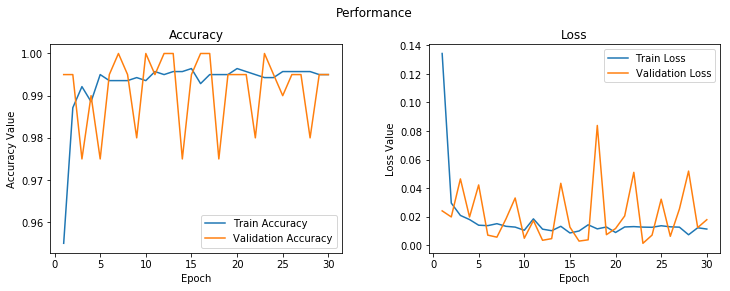

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
model.save('first_model.h5')

Evaluating

In [0]:
# load dependencies
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.models import load_model
import model_evaluation_utils as meu
%matplotlib inline

# load saved models
tl_cnn = load_model('first_model.h5')

# load other configurations
IMG_DIM = (100, 100)
input_shape = (100, 100, 3)
num2class_label_transformer = lambda l: ['false' if x == 0 else 'true' for x in l]
class2num_label_transformer = lambda l: [0 if x == 'false' else 1 for x in l]

# load VGG model for bottleneck features
from keras.applications import vgg16
from keras.models import Model
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                  input_shape=input_shape)
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features

In [0]:
IMG_DIM = (100, 100)

test_files = glob.glob('test_data/*')
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [fn.split('/')[1].split(' ')[0].strip() for fn in test_files]

test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

class2num_label_transformer = lambda l: [0 if x == 'false' else 1 for x in l]
test_labels_enc = class2num_label_transformer(test_labels)
#print(test_labels[0:5], test_labels_enc[0:5])

#le = LabelEncoder()
#le.fit(train_labels)
#test_labels_enc = le.transform(test_labels)


print('Test dataset shape:', test_imgs.shape)
print(test_labels[0:5], test_labels_enc[0:5])

Test dataset shape: (200, 100, 100, 3)
['true', 'false', 'false', 'true', 'false'] [1, 0, 0, 1, 0]


In [0]:
import model_evaluation_utils as meu

test_bottleneck_features = get_bottleneck_features(vgg_model, test_imgs_scaled)

from keras.models import load_model
tl_cnn = load_model('first_model.h5')

num2class_label_transformer = lambda l: ['false' if x == 0 else 'true' for x in l]

predictions = tl_cnn.predict_classes(test_bottleneck_features, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.995
Precision: 0.995
Recall: 0.995
F1 Score: 0.995

Model Classification report:
------------------------------
              precision    recall  f1-score   support

        true       0.99      1.00      1.00       100
       false       1.00      0.99      0.99       100

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200


Prediction Confusion Matrix:
------------------------------
              Predicted:      
                    true false
Actual: true   100        0   
        false  1          99  


/content/model_evaluation_utils.py:62: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels),
/content/model_evaluation_utils.py:64: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels))


In [0]:
meu.plot_model_roc_curve(tl_cnn, test_imgs_scaled, 
                         true_labels=[test_labels_enc], class_names=[0, 1])

ValueError: ignored